![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FTips&file=BigQuery+ML+and+Slots.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Tips/BigQuery%20ML%20and%20Slots.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FTips%2FBigQuery%2520ML%2520and%2520Slots.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Tips/BigQuery%20ML%20and%20Slots.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Tips/BigQuery%20ML%20and%20Slots.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

<a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Tips/BigQuery%20ML%20and%20Slots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigQuery ML and Slots

[BigQuery ML (BQML)](https://cloud.google.com/bigquery-ml/docs/introduction) uses [Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-definition-language) statements to do model training (or importing), feature preprocessing, hyperparameter tuning, model weights, feature & training info, evaluation, inference, explainations and exports. A good overview is found in the [End-to-end journey permodel](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey) reference.


<p align="center"><center>
  <img alt="Model Selection Guide" src="https://cloud.google.com/static/bigquery/images/ml-model-cheatsheet.svg" width="50%">
</center></p>


## Slots
BigQuery query execution runs on a concept known as [slots](https://cloud.google.com/bigquery/docs/slots) - a virtual CPU used to execute SQL queries.  BigQuery automatically calculates how many slots are needed for a query depending on size and complexity.  BigQuery dynamically manages the slot resource economy and queues work units until the needed slots is available.

$$\textrm{Commitment} \Longrightarrow \textrm{Reservation} \Longleftarrow \textrm{Assignment (Project, Job Type)}$$

**Commitment Plans**
>The default capacity of BigQuery is called On-Demand where projects are limited to 2000 slots. Customers can create [commitments](https://cloud.google.com/bigquery/docs/reservations-intro#commitments) for flat-rate slots in increments of 100 slots with no upper limit.  These offer graduated savings by length of commitment: minutes, monthly, yearly. Larger slot counts can handle larger jobs or more concurrent jobs.

**Reservations**
>The slot **commitments** are allocated to buckets called [reservations](https://cloud.google.com/bigquery/docs/reservations-intro#reservations) and BigQuery resources are assigned to the reservations.  This allows you to allocate slots in any way that matches the workload across your organization, including changing or shifting slots between reservations to match your needs.

**Assignments**
>Projects get access to slots by [assignments](https://cloud.google.com/bigquery/docs/reservations-intro#assignments) to **reservations**. A project may be directly assigned, or if a project is not directly assigned it can still inherit, and share, a reservation from a parent folder or organization that is assigned to a resevation. By default, all assigned projects also share the idle slots across reservations and they dynamically revert back to their assignments when needed without any disruption or loss of work. This [guide](https://cloud.google.com/bigquery/docs/reservations-workload-management) has tips on choices for managing workloads.

**Job Types**
>**Assignments** have a property that defines the type of job that can use the slots.  This is where the topic gets focused on BigQuery ML queries. Job Types are:
>- `QUERY`: SQL, DDL, DML, and BigQuery ML queries (internal)
>- `PIPELINE`: load, export and other pipeline jobs - default is free and uses a shared pool of slots
>- `ML_EXTERNAL`:  Some `MODEL_TYPE` values in `CREATE MODEL` use services adjacent to BigQuery like Vertex AI
>**note on multiple assignments**
>- To have a project run multiple job types you can:
>    - make multiple assignment for the same project to the same reservation with different job types
>    - assign a project to different reservations for different job types


## BQML Job Types

More than just a `QUERY` - sometimes!

There are two key types of components of BQML: The `CREATE MODEL` statement and `ML.*` functions.  The `ML.*` functions all use a job type of `QUERY` like any other SQL query.

**`CREATE MODEL ...`**

The `CREATE MODEL` statment has a parameter for the `MODEL_TYPE` that has different job type needs based on its value:
- Runs as job type = `QUERY`
  - examples for `MODEL_TYPE =` : `LINEAR_REG`, `LOGISTIC_REG`, `KMEANS`, ...
- Runs as job type = `ML_EXTERNAL`
  - example for `MODEL_TYPE =` : `AUTOML`, `BOOSTED_TREE_CLASSIFIER`, `BOOSTED_TREE_REGRESSOR`, `DNN_CLASSIFIER`, `DNN_REGRESSOR`, ...

**NOTE**
To use all model types with `CREATE MODEL` the project will need multiple assignments to reservation(s) for both job types: `QUERY` and `ML_EXTERNAL`.  


## On-Demand Usage (the default)

When a project does not have an assignment or has an assignment of `None` it uses on-demand pricing.  This covers BigQuery ML related queries as well with a few notes: 
- Creating models has a different price per GB than regular queries and depends on the model type (see [BigQuery ML on-demand pricing](https://cloud.google.com/bigquery/pricing#bqml))
- Using models with `ML.*` functions is the same price as queries: evaluation, inspection, prediction, ...
- `MODEL_TYPE = MATRIX_FACTORIZATION` does not work with on-demand.  This model type can still be used with a short term purchase of flex-slots which have commitments as short as 1 minute. 



---
## Capacity Management

From the GCP Console, in BigQuery, you create slot commitments, reservations and assignments under the `Capacity management` tab (under administration).  These assignments will default to a job type of `Query`.

If you write a `CREATE MODEL .... MODEL_TYPE = 'DNN_CLASSIFIER' ...` then a message appears in the banner of the console:
> "Reservation not found for project ############ to use ml external slots. Please create ml_external reservation assignments to run create model queries for BigQuery external models, https://cloud.google.com/bigquery/docs/reservations-workload-management#managing_your_workloads_by_using_reservations"

Attempting to submit the query is met with an error with the same message.

---

## Assignment with Job Type = ML_External

This assignment can be done in the console, with the command line or with SQL.  Instructions for these approachs follow.  Before doing this note that when a query is running that uses job_type = `ML_EXTERNAL` it behaves differently in that it cannote be pre-empted like other queries.  **RECALL** This only impacts `CREATE MODEL` statements with specific `MODEL_TYPE` values.


You may want to consider a reservation with fewer slots or even dedicated slots for these jobs in an active production environment.  When not in use these slots are available as idle slots for query jobs.

Documentation Links:
- [Idle Slots](https://cloud.google.com/bigquery/docs/reservations-intro#idle_slots)
- [Assign slots to BigQuery ML workloads](https://cloud.google.com/bigquery/docs/reservations-assignments#assign-ml-workload)

### Instructions for Using Console
- Go to the [console page for BigQuery](https://console.cloud.google.com/bigquery)
- In the navigation panel, go to the **Capacity Management** section
- Click the **Reservations** tab
- Expand the reservation that assigns the project the job need to run in (may be folder or organization level assignment)
- Expand the `...` actions options next to the reservation and click **Create Assignment**:

#### Screenshots
  - 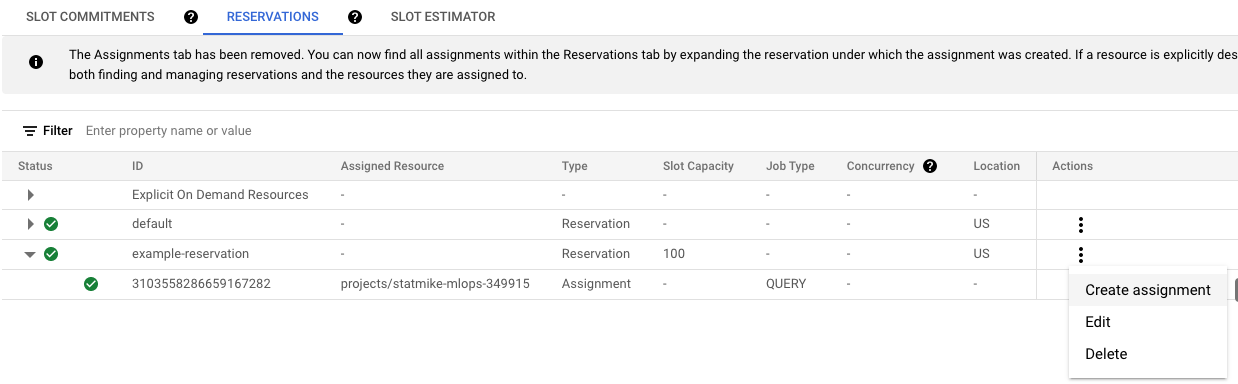
- Select the same project, folder, or organization and make the job_type - `ML_EXTERNAL` and the select **Create**
  - 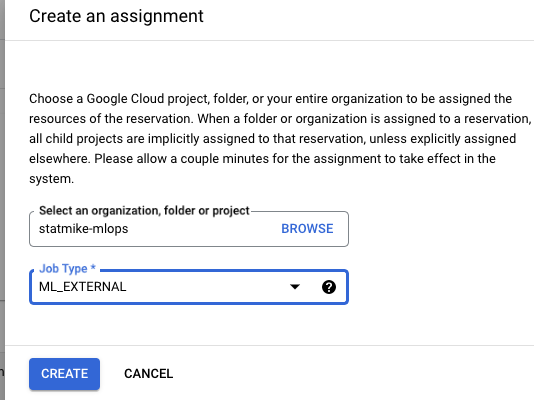
- Expanding the reservation should now show two assignments, one for each job type:
  - 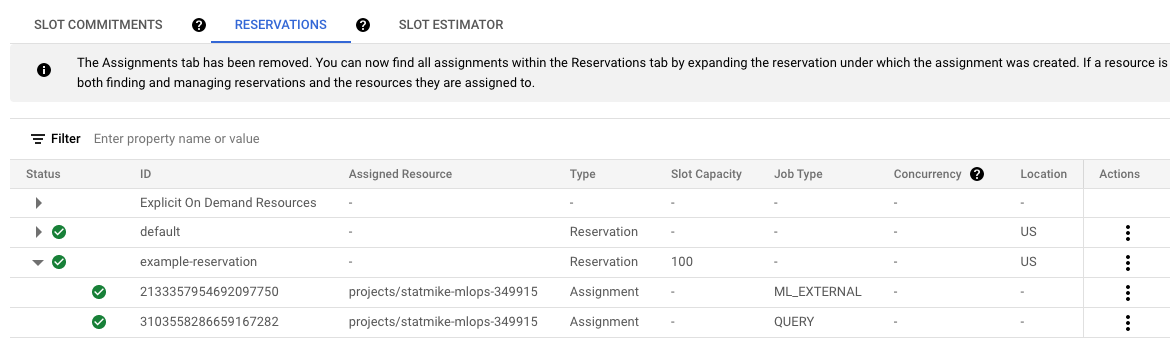


### Instructions for SQL

Use the `CREATE ASSIGNMENT` statement directly from BigQuery SQL to make assignments. [Reference](https://cloud.google.com/bigquery/docs/reservations-assignments#assign_my_prod_project_to_prod_reservation)

```SQL
CREATE ASSIGNMENT
  `{ADMIN_PROJECT_ID}.region-{REGION}.{RESERVATION_NAME}.{ASSIGNMENT_NAME}`
OPTIONS (
  assignee = 'projects/{BQ_PROJECT}',
  job_type = 'QUERY');

CREATE ASSIGNMENT
  `{ADMIN_PROJECT_ID}.region-{REGION}.{RESERVATION_NAME}.{ASSIGNMENT_NAME}`
OPTIONS (
  assignee = 'projects/{BQ_PROJECT}',
  job_type = 'ML_EXTERNAL');
```


### Instructions for Using Command Line

A more direct set of instructions for this modification can be found [here](https://cloud.google.com/bigquery/docs/reservations-assignments#assign-ml-workload).

To modify this to be a job type of `ML_EXTERNAL` you will need to use the `bq` command line tool as follows:

- While on the Capacity management tab, activate the Cloud Shell
- on the terminal line provide the instructions for the assignment

This assignment can be done for a project, folder, or oganization by adjusting `--assignee_type` and `--assignee_id` (details [here](https://cloud.google.com/bigquery/docs/reference/bq-cli-reference#mk-reservation_assignment)).  An example of a project assignment follows for reference:

#### Assign project to an additional reservation with job type of ML_EXTERNAL
```
bq mk \
  --project_id=statmike-project-1 \
  --location=US \
  --reservation_assignment \
  --reservation_id=ml-external \
  --job_type=ML_EXTERNAL\
  --assignee_id=statmike-project-1 \
  --assignee_type=PROJECT
```

#### Assign project to same reservation but with job type of ML_EXTERNAL
```
bq mk \
  --project_id=statmike-project-1 \
  --location=US \
  --reservation_assignment \
  --reservation_id=query \
  --job_type=ML_EXTERNAL\
  --assignee_id=statmike-project-1 \
  --assignee_type=PROJECT
```
This will show up under the reservation in the console as an additional row for the the resource (project) assigned to the same reservation but with the Job Type of `ML_EXTERNAL`


#### Screenshots

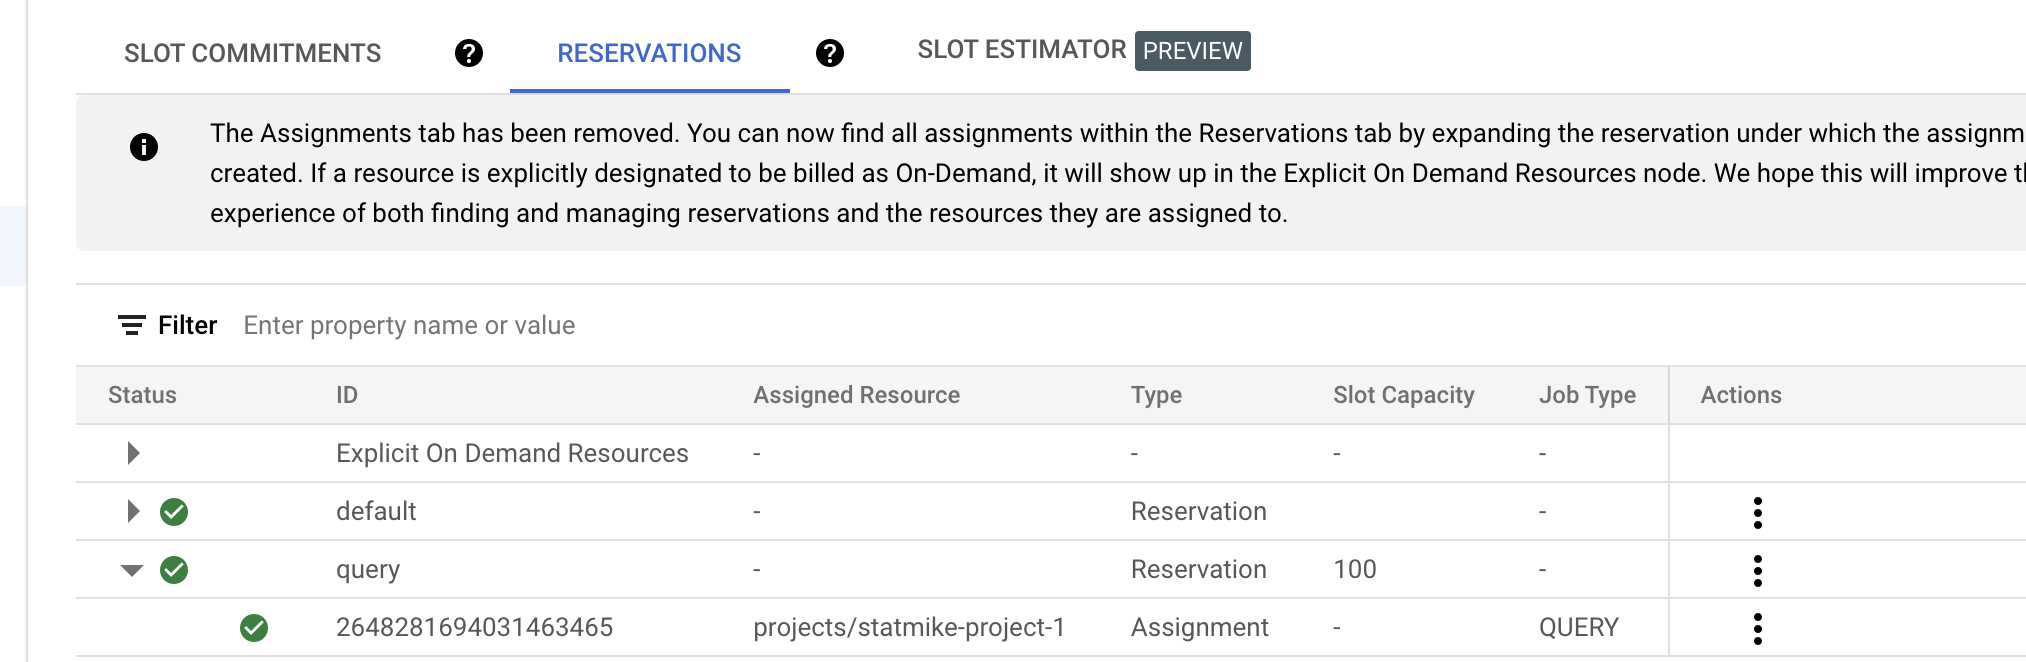

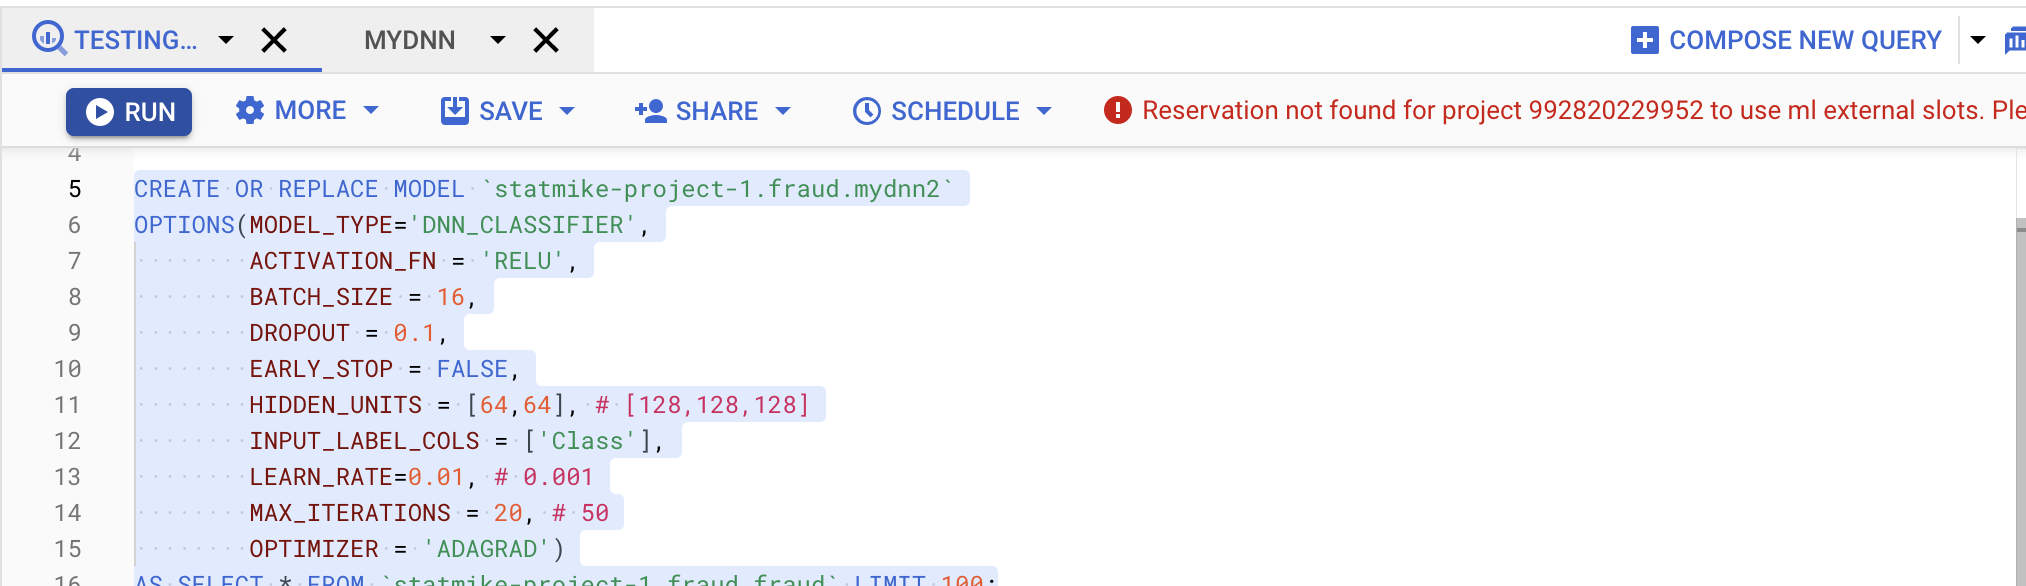

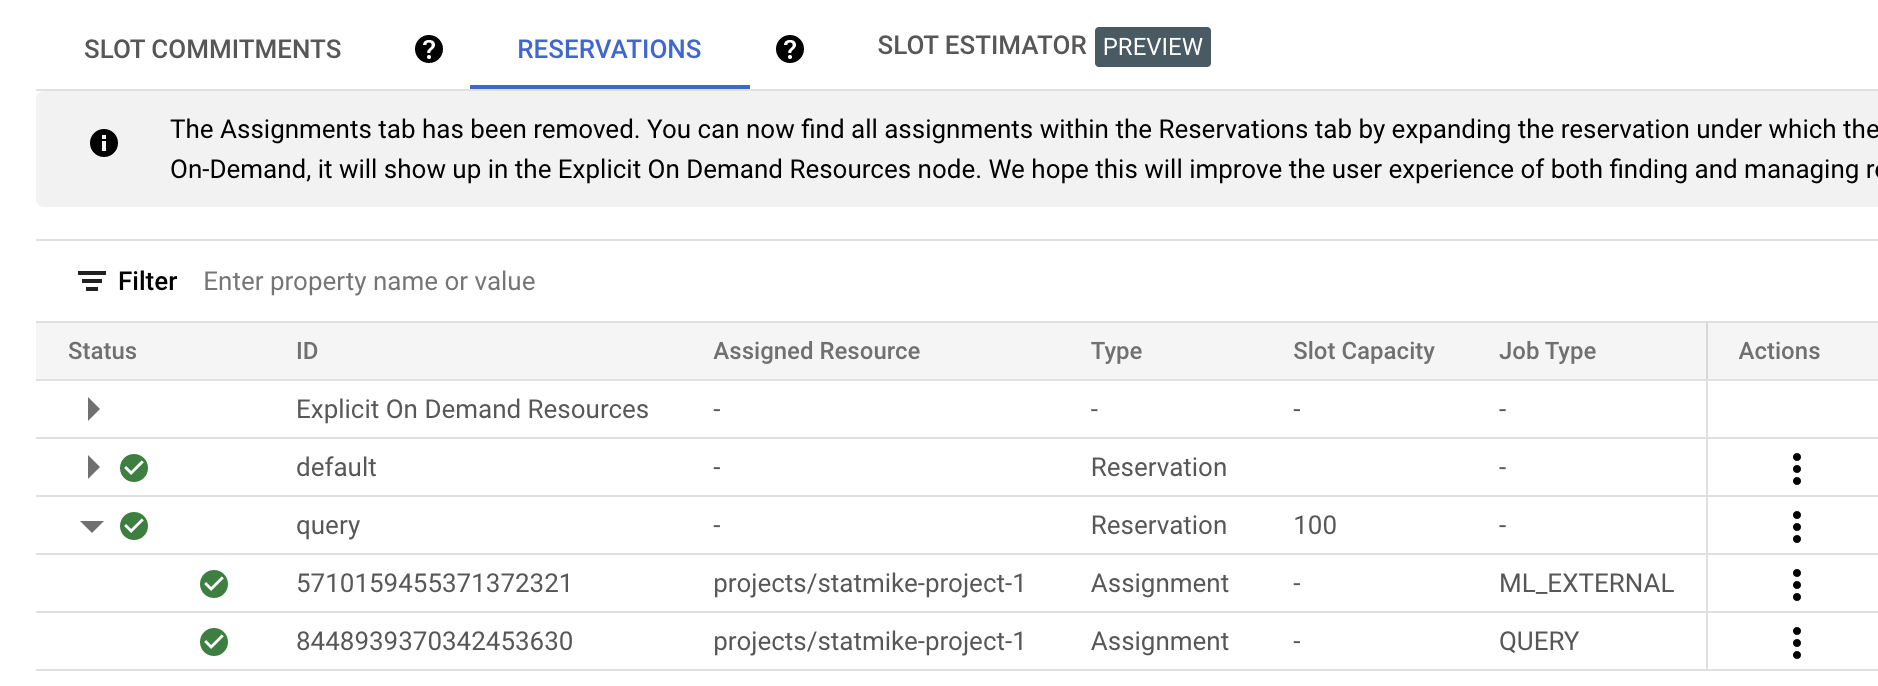

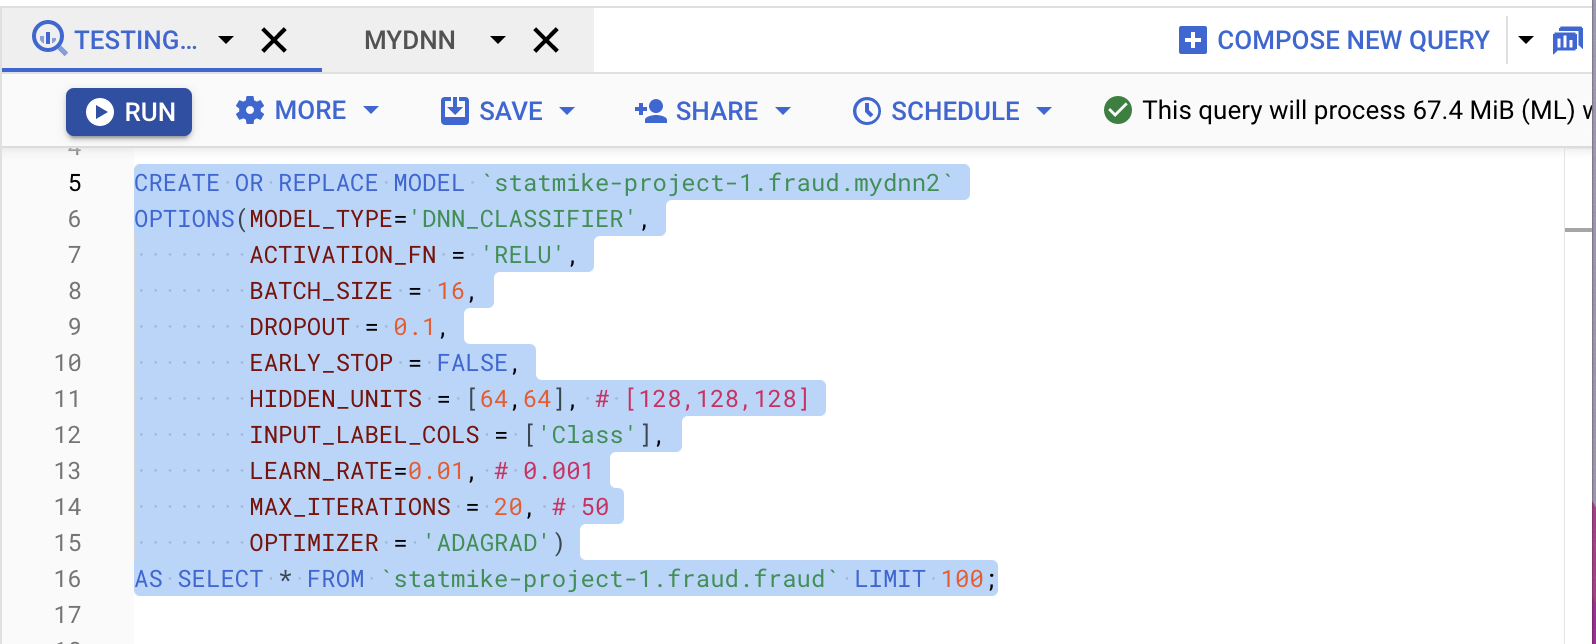

---
## Flex Slot Commitments As A Workflow

If you use the default BigQuery commitment of on-demand and need access to slots then a temporary solution might be using a [flex slots commitment](https://cloud.google.com/bigquery/docs/reservations-details#flex_slots_plans) that has a minimum usage of 1 minute and can be canceled anytime after - like when your job is finished. 

This might be useful if you are trying to use a BQML feature that does not work with on-demand usage, like `MODEL_TYPE = MATRIX_FACTORIZATION`.  This following is an example of using SQL to setup flex slots for usage and then cancel them.  **Note that this will also impact other queries in the same project as well**

**WORKFLOW**

$$\textrm{Commitment} \Longrightarrow \textrm{Reservation} \Longleftarrow \textrm{Assignment (Project, Job Type)} \newline \textrm{Run Query(s)} \newline \textrm{Drop Assignment} \Longrightarrow \textrm{Drop Reservation} \Longrightarrow \textrm{Drop Commitement}$$


**ENABLE The BigQuery Reservations API**

The [BigQuery Reservations API](https://console.cloud.google.com/apis/library/bigqueryreservation.googleapis.com) is needed to create commitment, reservations and assigments. [Reference](https://cloud.google.com/bigquery/docs/reservations-commitments#enabling-reservations-api)

**CREATE a Commitment to Flex Slot**

Purchase flex slots.  These come in 100 slots increments, only charged for minutes used prior to cancelling.  Pricing can be reviewed [here](https://cloud.google.com/bigquery/pricing#flat-rate_analysis_pricing).  At this time the rate for 100 slots is $4/hour for the US multi-region, or $0.066667/minute. Slot purchases are a regional resource, purchase using the region/multi-region of the dataset you are planning to use. [Reference](https://cloud.google.com/bigquery/docs/reservations-commitments#create_a_capacity_commitment)

```SQL
CREATE CAPACITY `{ADMIN_PROJECT_ID}.region-{REGION}.{COMMITMENT_NAME}`
    OPTIONS (
      slot_count = {NUMBER_OF_SLOTS},
      plan = 'FLEX'
    );
```

**CREATE a Reservation With The Slots**

Create a reservation to hold the new commited slots.  [Reference](https://cloud.google.com/bigquery/docs/reservations-tasks#create_reservations)

```SQL
CREATE RESERVATION `{ADMIN_PROJECT_ID}.region-{REGION}.{RESERVATION_NAME}`
    OPTIONS (
      slot_capacity = {NUMBER_OF_SLOTS}
    );
```

**CREATE an Assignment For The Project to the Reservation**

Assign the desired project to the new reservation. [Reference](https://cloud.google.com/bigquery/docs/reservations-assignments#create_reservation_assignments)

```SQL
CREATE ASSIGNMENT `{ADMIN_PROJECT_ID}.region-{REGION}.{RESERVATION_NAME}.{ASSIGNMENT_NAME}`
    OPTIONS (
      assignee = 'project/{PROJECT_ID}',
      job_type = 'QUERY'
    );
```

>**NOTES**
>- To use multiple job types, like `QUERY` and `ML_EXTERNAL`, make multiple `CREATE ASSIGNMENT` statements.
>- There may be a very short delay for the assignment to impact new queries, if a query results in an error due to job type of the assignment try again after a few seconds.

**Run The Desired Queries, like `CREATE MODEL`**

Run the desired queries here!


**REMOVE the Assigment**

As soon as you are done with the queries that needed the flex slot commitment proceed with removing the commitment.  First remove the assignment (here), then the reservation holding the slots, then the commitment to the slots.

Drop the assigment with the following statement. [Reference](https://cloud.google.com/bigquery/docs/reservations-assignments#delete_reservation_assignments)

```SQL
DROP ASSIGNMENT `{ADMIN_PROJECT_ID}.region-{REGION}.{RESERVATION_NAME}.{ASSIGNMENT_NAME}`;
```

**REMOVE the Reservation**

Once the assignment is removed drop the reservation. [Reference](https://cloud.google.com/bigquery/docs/reservations-tasks#delete_reservations)

```SQL
DROP RESERVATION `{ADMIN_PROJECT_ID}.region-{REGION}.{RESERVATION_NAME}`;
```

**REMOVE the Commitment**

The last and most important part is dropping the flex slot commitment to stop charges. [Reference](https://cloud.google.com/bigquery/docs/reservations-commitments#delete_a_commitment)

```SQL
DROP CAPACITY `{ADMIN_PROJECT_ID}.region-{REGION}.{COMMITMENT_NAME}`;
```